In [7]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('earnings_train.csv')

# Handle missing values
train_df['DISTRICT_CODE'] = train_df['DISTRICT_CODE'].fillna(0)

# Create engineered features
train_df['avg_wage_prev_years'] = (train_df['WAGE_YEAR1'] + train_df['WAGE_YEAR2'] + train_df['WAGE_YEAR3']) / 3
train_df['wage_trend'] = train_df['WAGE_YEAR3'] - train_df['WAGE_YEAR1']
train_df['most_recent_wage'] = train_df['WAGE_YEAR3']

# Encode categorical variables
categorical_cols = ['DISTRICT_TYPE', 'DEMO_CATEGORY', 'AWARD_CATEGORY', 'STUDENT_POPULATION']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

# Define target and features
target = 'WAGE_YEAR4'
y = train_encoded[target]

columns_to_drop = ['DISTRICT_NAME', 'ACADEMIC_YEAR', 'DISTRICT_CODE',
                   'WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3', 'WAGE_YEAR4']
X = train_encoded.drop(columns=columns_to_drop, errors='ignore')

# Split data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 16564 samples
Validation set: 4141 samples


In [38]:
# Linear Regression - Model 1
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_val)
lr_rmse = np.sqrt(mean_squared_error(y_val, lr_predictions))
lr_r2 = r2_score(y_val, lr_predictions)

# CART Decision Tree - Model 2
dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=20, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_val)
dt_rmse = np.sqrt(mean_squared_error(y_val, dt_predictions))
dt_r2 = r2_score(y_val, dt_predictions)

# Display RSME
print("--------------------")
print("MODEL PERFORMANCE")
print("--------------------")
print(f"Linear Regression          → RMSE: {lr_rmse:.2f}")
print(f"Best Model - Decision Tree → RMSE: {dt_rmse:.2f}")
print("--------------------")

# Grade
if best_rmse < 2500:
    print("Model is under 2500 - Exempleray")
elif best_rmse <= 3000:
    print("Model is under 3000 - Satisfactory")
else:
    print("Needs Improvement - Partial")

--------------------
MODEL PERFORMANCE
--------------------
Linear Regression          → RMSE: 2449.08
Best Model - Decision Tree → RMSE: 2248.70
--------------------
Model is under 2500 - Exempleray


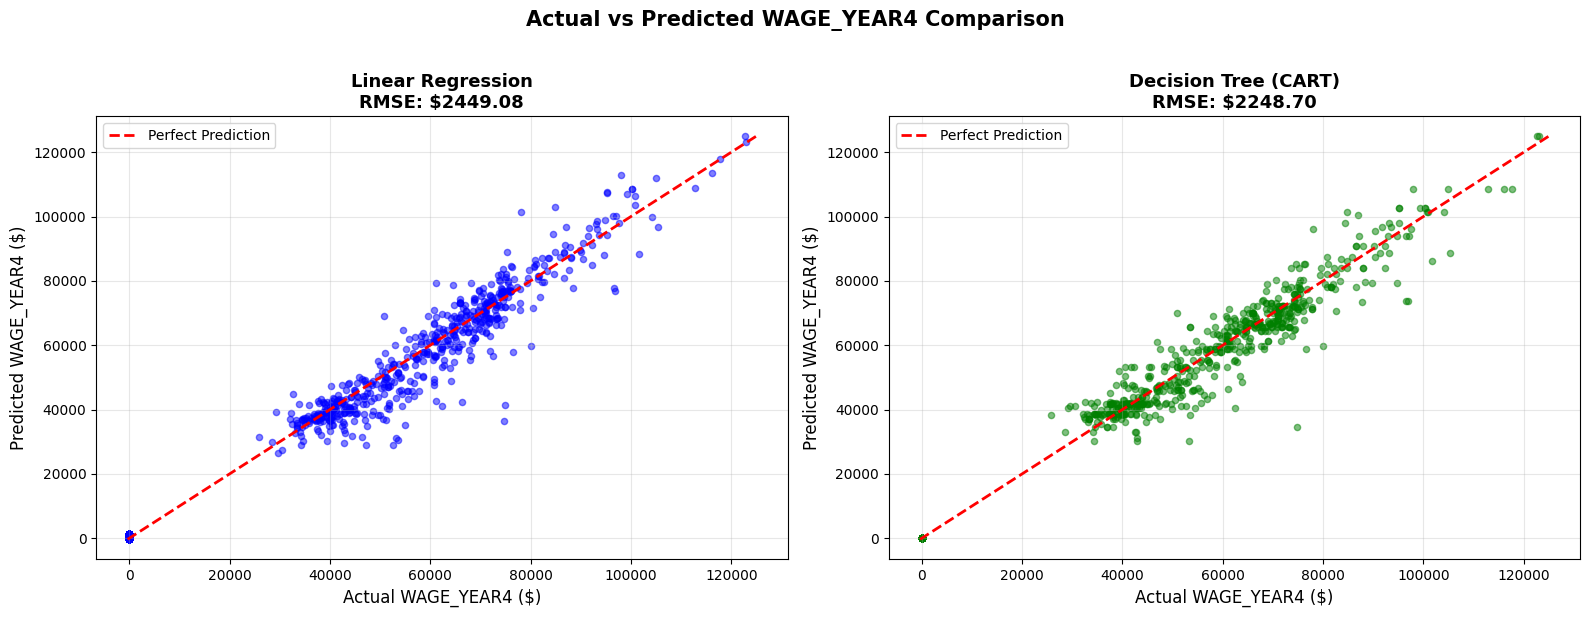

Graph saved as 'actual_vs_predicted_comparison.png'


In [36]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression plot
ax1 = axes[0]
ax1.scatter(y_val, lr_predictions, alpha=0.5, s=20, color='blue')
min_val = min(y_val.min(), lr_predictions.min())
max_val = max(y_val.max(), lr_predictions.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual WAGE_YEAR4 ($)', fontsize=12)
ax1.set_ylabel('Predicted WAGE_YEAR4 ($)', fontsize=12)
ax1.set_title(f'Linear Regression\nRMSE: ${lr_rmse:.2f}', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Decision Tree plot
ax2 = axes[1]
ax2.scatter(y_val, dt_predictions, alpha=0.5, s=20, color='green')
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual WAGE_YEAR4 ($)', fontsize=12)
ax2.set_ylabel('Predicted WAGE_YEAR4 ($)', fontsize=12)
ax2.set_title(f'Decision Tree (CART)\nRMSE: ${dt_rmse:.2f}', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('Actual vs Predicted WAGE_YEAR4 Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('actual_vs_predicted_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graph saved as 'actual_vs_predicted_comparison.png'")

In [41]:
# Load test data
test_df = pd.read_csv('earnings_test_features.csv')

# Apply same preprocessing
test_df['DISTRICT_CODE'] = test_df['DISTRICT_CODE'].fillna(0)
test_df['avg_wage_prev_years'] = (test_df['WAGE_YEAR1'] + test_df['WAGE_YEAR2'] + test_df['WAGE_YEAR3']) / 3
test_df['wage_trend'] = test_df['WAGE_YEAR3'] - test_df['WAGE_YEAR1']
test_df['most_recent_wage'] = test_df['WAGE_YEAR3']

# Encode categorical variables
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Prepare features
X_test = test_encoded.drop(columns=columns_to_drop, errors='ignore')
X_test = X_test.reindex(columns=X.columns, fill_value=0)

print("--------------------")
print("MAKING PREDICTIONS WITH ENSEMBLE")
print("--------------------")

# Retrain BOTH models on full training data
lr_model.fit(X, y)
dt_model.fit(X, y)

# Get predictions from both models
lr_test_preds = lr_model.predict(X_test)
dt_test_preds = dt_model.predict(X_test)

# ENSEMBLE: Average the two models
test_predictions = (lr_test_preds + dt_test_preds) / 2

# Clip negative predictions to 0
test_predictions = np.maximum(test_predictions, 0)

print(f"Linear Regression predictions - Mean: {lr_test_preds.mean():.2f}")
print(f"Decision Tree predictions - Mean: {dt_test_preds.mean():.2f}")
print(f"Ensemble (averaged) predictions - Mean: {test_predictions.mean():.2f}")

# Save predictions
predictions_df = pd.DataFrame({'WAGE_YEAR4': test_predictions})
predictions_df.to_csv('preds.csv', index=False)

print("--------------------")
print("PREDICTIONS COMPLETE")
print("--------------------")
print(f"Total predictions: {len(predictions_df)}")
print(f"Zero predictions: {(predictions_df['WAGE_YEAR4'] == 0).sum()}")
print(f"Percentage zero: {(predictions_df['WAGE_YEAR4'] == 0).sum() / len(predictions_df) * 100:.1f}%")
print(f"Mean prediction: {predictions_df['WAGE_YEAR4'].mean():.2f}")
print(f"Median prediction: {predictions_df['WAGE_YEAR4'].median():.2f}")
print(f"Min prediction: {predictions_df['WAGE_YEAR4'].min():.2f}")
print(f"Max prediction: {predictions_df['WAGE_YEAR4'].max():.2f}")
print("--------------------")

--------------------
MAKING PREDICTIONS WITH ENSEMBLE
--------------------
Linear Regression predictions - Mean: 8733.58
Decision Tree predictions - Mean: 8716.29
Ensemble (averaged) predictions - Mean: 8774.70
--------------------
PREDICTIONS COMPLETE
--------------------
Total predictions: 6902
Zero predictions: 2920
Percentage zero: 42.3%
Mean prediction: 8774.70
Median prediction: 46.88
Min prediction: 0.00
Max prediction: 136232.66
--------------------
